# Homework 7

In this homework you will be training and using a "char-RNN". This is the name given to a character-level recurrent neural network language model by [this famous blog post by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Before you start on the rest of the homework, please give the blog post a read, it's quite good!

I don't expect you to implement the char-RNN from scratch. Andrej's original char-rnn is in Torch (the predecessor to PyTorch that is not commonly used anymore). Fortunately, there are many other implementations of this model available; for example, there is one (in both mxnet and pytorch) in chapters 8 and 9 of [the textbook](http://d2l.ai), and another pytorch one [here](https://github.com/spro/char-rnn.pytorch). **Please use one of these example implementations (or another one that you find) when completing this homework**.

For this homework, please complete the following steps:

1. Download and tokenize the [Shakespeare dataset](http://www.gutenberg.org/files/100/100-0.txt) at a character level. I recommend basing your solution on the following code:
```Python
# Remove non-alphabetical characters, lowercase, and replace whitespace with ' '
raw_dataset = ' '.join(re.sub('[^A-Za-z ]+', '', text).lower().split())
# Maps token index to character
idx_to_char = list(set(raw_dataset))
# Maps character to token index
char_to_idx = dict([(char, i) for i, char in enumerate(idx_to_char)])
# Tokenize the dataset
corpus_indices = [char_to_idx[char] for char in raw_dataset]
```
1. Train a "vanilla" RNN (as described in chapter 9 of [the textbook](http://d2l.ai)) on the Shakespeare dataset. Report the training loss and generate some samples from the model at the end of training.
1. Train a GRU RNN (as described in chapter 10 of [the textbook](http://d2l.ai)) on the Shakespeare datatset. Is the final training loss higher or lower than the vanilla RNN? Are the samples from the model more or less realistic?
1. Find a smaller, simpler dataset than the Shakespeare data (you can find some ideas in Andrej's blog post, but feel free to get creative!) and train either the vanilla or GRU RNN on it instead. Is the final training loss higher or lower than it was for the Shakespeare data?

In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.9 MB/s eta 0:00:00


In [34]:
import requests
import numpy as np
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from torch.optim import Adam
import matplotlib.pyplot as plt


## 0. Download The Dataset

In [ ]:
url = "https://www.gutenberg.org/files/100/100-0.txt"
  
r = requests.get(url, stream = True)
raw_data = ' '.join(re.sub('[^A-Za-z ]+', ' ', r.text).lower().split())

## 1. Character Level Tokenizer

In [3]:
class Tokenizer(object):
    def __init__(self, 
                 pad_token="<PAD>",
                 oov_token="<UNK>",
                 token_to_index=None
                 ):
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.n_tokens = 2
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit(self, texts):
        all_tokens = set(texts)
        for token in all_tokens:
            self.token_to_index[token] = self.n_tokens
            self.index_to_token[self.n_tokens] = token
            self.n_tokens += 1
    
    def max_pad_sequences(self, sequences):
        """
        Pad sequences to the longest length in batch.
        """
        max_len = len(max(sequences, key=len))
        padded_sequences = np.zeros((len(sequences), max_len))
        for i, sequence in enumerate(sequences):
            padded_sequences[i][:len(sequence)] = sequence
        return padded_sequences

    def encode(self, texts):
        sequences = []
        for text in texts:
            sequence = []
            for token in text:
                
                sequence.append(self.token_to_index.get(
                    token.lower(), self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        padded_seqs = self.max_pad_sequences(sequences)
        return torch.LongTensor(np.array(padded_seqs))

    def decode(self, sequences):
        texts = []
        for sequence in sequences.cpu().numpy():
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append("".join([token for token in text]))
        return texts

In [4]:
tokenizer = Tokenizer()
tokenizer.fit(raw_data)

tokenizer.decode(tokenizer.encode(['This is a longer text',
                 'Smaller text']))

['this is a longer text',
 'smaller text<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, raw_data, tokenizer, timesteps):
        self.data = raw_data
        self.tokenizer = tokenizer
        self.timesteps = timesteps

    def __len__(self):
        return len(self.data)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.data[index: index + self.timesteps + np.random.randint(0,4)]
        return X

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        X = tokenizer.encode(batch) 
        return X

    def create_dataloader(self, batch_size, shuffle=False, drop_last=True):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True)


In [6]:
dset = Dataset(raw_data, tokenizer, 72)
dloader = dset.create_dataloader(64, shuffle=True)
tokenizer.decode(next(iter(dloader)))

['r since jupiter our son is good take off his miseries sicilius peep throug<PAD>',
 ' it goes i writ at random very doubtfully silvia perchance you think too mu',
 'hangman i would be glad to receive some instructions from my fellow partne<PAD>',
 'se the iron cools warwick i had rather chop this hand off at a blow and wit',
 'n she stops his lips and kissing speaks with lustful language broken if t<PAD><PAD>',
 'in charge beget your happiness be happy then for it is done king richard bu',
 'er spring this carry tale dissentious jealousy that sometime true news s<PAD><PAD><PAD>',
 'illa ascii or other format used in the official version posted on the of<PAD><PAD><PAD>',
 't you gentlemen i ll compound this strife tis deeds must win the prize and ',
 'e come take it up second servant pray heaven it be not full of knight agai<PAD>',
 'oth teach us all to render the deeds of mercy i have spoke thus much to mi<PAD>',
 'hers death enter a messenger a fearful eye thou hast where is that blo

## 2. Vanilla RNN

In [7]:
class RNNcell(nn.Module):
    """
    Implement the Vanilla RNN cell from "scratch".
    s/o to Torch community for handling the 
    heavy lifting.
    """
    def __init__(self, input_dim, hidden_dim, sigma=.01):
        super(RNNcell, self).__init__()
        # Save H-params
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.sigma = sigma
        # Initialize Net Parameters
        self.W_xh = self.weight_init(input_dim, hidden_dim)
        self.W_hh = self.weight_init(hidden_dim, hidden_dim)
        self.b_h = self.bias_init() 
    
    # Initialize weight
    def weight_init(self, *shape):
        return nn.Parameter(torch.randn(shape)*self.sigma)
    
    # Initialize bias
    def bias_init(self):
        return nn.Parameter(torch.zeros(self.hidden_dim))
    
    # Define the forward pass for a single timestep
    def forward(self, x_t, h_t):
        h_t = torch.tanh(torch.matmul(x_t, self.W_xh)
                                  + torch.matmul(h_t, self.W_hh)
                                  + self.b_h)
                
        return h_t

In [21]:
class LanguageModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, model, m_layers):
        # Save hyperparams
        super(LanguageModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.m_layers = m_layers
        # Set up nework flow       
        self.emb = nn.Embedding(input_dim, hidden_dim, padding_idx=0)
        self.layers = [model(hidden_dim, hidden_dim)]*m_layers
        self.fc = nn.Linear(hidden_dim, output_dim)
        
     
    def forward(self, x_t, h_t=None):
        """
        On the forward pass, compute the pass of one timestep
        with the hidden states accumulating the info from prev steps
        """
        # Initialize for the first token
        if h_t is None:
            hiddens = [torch.zeros((x_t.shape[0], self.hidden_dim))]*self.m_layers
        else:
            hiddens = h_t
        # First embed the inputs with shape (bsz, hidden_dim)
        inp = self.emb(x_t) 
        # Pass it through the RNN
        for i, layer in enumerate(self.layers):
            # Pass it through the hidden layer and update
            hiddens[i] = layer(inp, hiddens[i])
            # Update the input to the next layer as this hidden state
            inp = hiddens[i]    

        o_t = self.fc(inp)
        return o_t, hiddens
            

In [37]:
lm = LanguageModel(tokenizer.n_tokens, 32, tokenizer.n_tokens, RNNcell, 2)
sample = next(iter(dloader))
rearr = rearrange(sample, 'bsz timesteps -> timesteps bsz ')
ot, ht = lm(rearr[0])
lm(rearr[1], ht)

(tensor([[-0.1538, -0.0206,  0.1654,  ...,  0.1515,  0.0057,  0.1145],
         [-0.1572, -0.0189,  0.1631,  ...,  0.1528,  0.0066,  0.1140],
         [-0.1569, -0.0198,  0.1642,  ...,  0.1526,  0.0073,  0.1132],
         ...,
         [-0.1533, -0.0211,  0.1646,  ...,  0.1510,  0.0066,  0.1140],
         [-0.1557, -0.0193,  0.1641,  ...,  0.1537,  0.0078,  0.1136],
         [-0.1538, -0.0211,  0.1646,  ...,  0.1511,  0.0066,  0.1140]],
        grad_fn=<AddmmBackward0>),
 [tensor([[ 0.0179,  0.0370,  0.0968,  ...,  0.0176,  0.0292,  0.0124],
          [ 0.0492, -0.0394,  0.0952,  ...,  0.0160, -0.0288, -0.0079],
          [ 0.0747,  0.1232,  0.1251,  ..., -0.0147, -0.0520,  0.0125],
          ...,
          [ 0.0507,  0.0124,  0.1101,  ..., -0.0752, -0.0204,  0.0151],
          [-0.0549,  0.0768, -0.0019,  ..., -0.0790, -0.1190, -0.0329],
          [ 0.0520,  0.0106,  0.1100,  ..., -0.0760, -0.0245,  0.0117]],
         grad_fn=<TanhBackward0>),
  tensor([[ 0.0009,  0.0012, -0.0076,  ..

In [83]:
class Trainer(object):
    def __init__(self, model, dataset, bsz, criterion=None, optimizer=None, scheduler=None):
        # Set params
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model
        self.batch_size = bsz
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.dataloader = dataset.create_dataloader(bsz, shuffle=True)
        self.tokenizer = dataset.tokenizer

    def train_step(self):
        """Train step."""
        # Set model to train mode
        self.model.train()
        
        loss = 0.0                          # Batch Loss
        batch = next(iter(self.dataloader))    
        # Rearrange to get (timesteps, bsz)
        rbatch = rearrange(batch, 'bsz timesteps -> timesteps bsz')
        inputs, targets = rbatch[:-1], rbatch[1:]
        self.optimizer.zero_grad()
        # Initialize hidden
        hidden = None
        for t in range(len(rbatch)-1):
            out, hidden =  self.model(inputs[t], hidden)
            loss += self.criterion(out, targets[t])
        
        loss.backward()  # Backward pass
        self.optimizer.step()  # Update weights

        return loss.detach().item()/len(batch)

    def train_iters(self, num_iters, log_every=10):
        batch_loss = []
        
        for iter in range(num_iters):
            
            # Steps
            train_loss = self.train_step()
            #self.scheduler.step()
            batch_loss += [train_loss]

            if (iter + 1) % log_every == 0: 
                # Logging
                print(
                    f"Iteration: {iter+1} | "
                    f"train_loss: {train_loss:.5f}, "
                    f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                    f"Sampled Output:{self.evaluate()}"
                )

        return self.model, batch_loss

    def evaluate(self, seed_sequence='Thou', output_length=25):
        warmup = self.tokenizer.encode(seed_sequence)
        # Start the output with the seed sequence
        output = seed_sequence
        #hidden = [torch.zeros((self.batch_size, self.hidden_dim))]*self.model.m_layers
        hidden = None
        # Warmup the RNN hidden states with the priming
        for p in range(len(seed_sequence) - 1):
            _, hidden = self.model(warmup[p], hidden)

        # Start the from end of warmup sequence
        inp = warmup[-1]

        for t in range(output_length):
            o_t, hidden = self.model(inp, hidden)
            idx = torch.argmax(o_t, dim=1).unsqueeze(0)
            char = tokenizer.decode(idx)[0]
            output += char
            inp = tokenizer.encode(char)[0]
        return output

In [84]:
optimizer = Adam(lm.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3)

In [85]:
tr = Trainer(lm, dset, 64, criterion, optimizer)

In [86]:
opt_rnn, b_loss = tr.train_iters(1000, log_every=100)

Iteration: 100 | train_loss: 3.79043, lr: 1.00E-03, Sampled Output:Thoutttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt
Iteration: 200 | train_loss: 3.70923, lr: 1.00E-03, Sampled Output:Thoutttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt
Iteration: 300 | train_loss: 3.64242, lr: 1.00E-03, Sampled Output:Thou ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt
Iteration: 400 | train_loss: 3.58219, lr: 1.00E-03, Sampled Output:Thou                                                                                                    
Iteration: 500 | train_loss: 3.53897, lr: 1.00E-03, Sampled Output:Thou                                                                                                    
Iteration: 600 | train_loss: 3.48120, lr: 1.00E-03, Sampled Output:Thou                                                                     

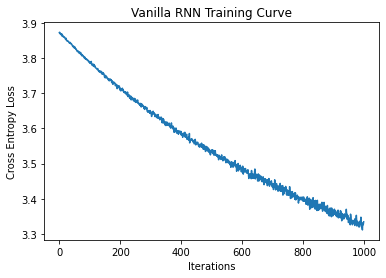

In [87]:
plt.plot(b_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iterations')
plt.title('Vanilla RNN Training Curve')
plt.show()

In [88]:
tr.evaluate(seed_sequence="On a dark and mysterious", output_length=200)

'On a dark an mysterious                                                                                                                                                                                                        '

## 3. GRU RNN

In [36]:
class GRUcell(nn.Module):
    """
    Implement the GRU cell from "scratch".
    s/o to Torch community for handling the 
    heavy lifting.
    """
    def __init__(self, input_dim, hidden_dim, sigma=.01):
        super(GRUcell, self).__init__()
        # Save H-params
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.sigma = sigma
        # Initialize Net Parameters
        self.W_xr, self.W_hr, self.b_r = self.gate_init()
        self.W_xz, self.W_hz, self.b_z = self.gate_init()
        self.W_xh, self.W_hh, self.b_h = self.gate_init()
        
    def gate_init(self):
        gate_params =  (self.weight_init(self.input_dim, self.hidden_dim),
                self.weight_init(self.hidden_dim, self.hidden_dim),
                self.bias_init())
        return gate_params
    
    def weight_init(self, *shape):
        return nn.Parameter(torch.randn(shape)*self.sigma)
    
    def bias_init(self):
        return nn.Parameter(torch.zeros(self.hidden_dim))
    
    def init_hidden(self):
        return (torch.zeros(self.hidden_dim), torch.zeros(self.hidden_dim))
    
    def forward(self, x_t, h_t):
        
        reset_gate = torch.sigmoid(torch.matmul(x_t, self.W_xr)
                                  + torch.matmul(h_t, self.W_hr)
                                  + self.b_r)
        update_gate = torch.sigmoid(torch.matmul(x_t, self.W_xz)
                                  + torch.matmul(h_t, self.W_hz)
                                  + self.b_z)
        candidate_h = torch.tanh(torch.matmul(x_t, self.W_xh)
                                  + torch.matmul((update_gate * h_t), self.W_hh)
                                  + self.b_h)
        
        h_t = update_gate * h_t + (1-update_gate) * candidate_h
        
        return h_t

In [55]:
lm2 = LanguageModel(tokenizer.n_tokens, 32, tokenizer.n_tokens, GRUcell, 1)
sample = next(iter(dloader))
rearr = rearrange(sample, 'bsz timesteps -> timesteps bsz ')
ot, ht = lm(rearr[0])
lm(rearr[1], ht)

(tensor([[-0.1563, -0.0209,  0.1632,  ...,  0.1511,  0.0077,  0.1121],
         [-0.1533, -0.0211,  0.1645,  ...,  0.1511,  0.0065,  0.1140],
         [-0.1533, -0.0211,  0.1645,  ...,  0.1511,  0.0065,  0.1140],
         ...,
         [-0.1573, -0.0229,  0.1630,  ...,  0.1509,  0.0034,  0.1163],
         [-0.1555, -0.0223,  0.1647,  ...,  0.1542,  0.0083,  0.1129],
         [-0.1565, -0.0213,  0.1632,  ...,  0.1510,  0.0077,  0.1123]],
        grad_fn=<AddmmBackward0>),
 [tensor([[ 0.0405,  0.0391, -0.0526,  ..., -0.0241,  0.0223,  0.0381],
          [ 0.0486,  0.0099,  0.1132,  ..., -0.0733, -0.0244,  0.0126],
          [ 0.0486,  0.0099,  0.1132,  ..., -0.0733, -0.0244,  0.0126],
          ...,
          [-0.0024, -0.0765,  0.0086,  ...,  0.0293,  0.0365,  0.0457],
          [-0.0538, -0.0083, -0.0453,  ...,  0.0199, -0.0565,  0.0581],
          [ 0.0355,  0.0358, -0.0456,  ..., -0.0289,  0.0209,  0.0434]],
         grad_fn=<TanhBackward0>),
  tensor([[-0.0027, -0.0048, -0.0017,  ..

In [71]:
gru_optimizer = Adam(lm2.parameters(), lr=1e-3)
gru_criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3)

In [72]:
gru_trainer = Trainer(lm2, dset, 64, gru_criterion, gru_optimizer)

In [73]:
opt_gru, gru_loss = gru_trainer.train_iters(100, log_every=10)

Iteration: 10 | train_loss: 3.86294, lr: 1.00E-03, 
Iteration: 20 | train_loss: 3.85018, lr: 1.00E-03, 
Iteration: 30 | train_loss: 3.83724, lr: 1.00E-03, 
Iteration: 40 | train_loss: 3.82540, lr: 1.00E-03, 
Iteration: 50 | train_loss: 3.80931, lr: 1.00E-03, 
Iteration: 60 | train_loss: 3.80024, lr: 1.00E-03, 
Iteration: 70 | train_loss: 3.78336, lr: 1.00E-03, 
Iteration: 80 | train_loss: 3.76947, lr: 1.00E-03, 
Iteration: 90 | train_loss: 3.75428, lr: 1.00E-03, 
Iteration: 100 | train_loss: 3.73905, lr: 1.00E-03, 


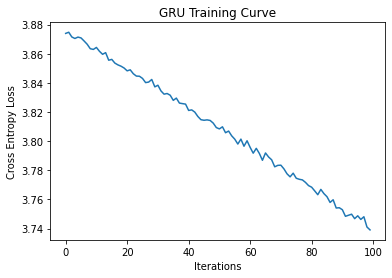

In [74]:
plt.plot(gru_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iterations')
plt.title('GRU Training Curve')
plt.show()

In [75]:
gru_trainer.evaluate(seed_sequence="On a dark an mysterious", output_length=200)

'On a dark an mysterious iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii'

## 4. Truncated Dataset

In [66]:
url2 = "http://web.textfiles.com/politics/disneyte.txt"
  
r = requests.get(url2, stream = False)
wd_data = ' '.join(re.sub('[^A-Za-z ]+', ' ', r.text).lower().split())

In [67]:
wd_data

'newsgroups rec arts disney from tanida seismo css gov tom tanida subject transcript of walt disney s testimony oct k file message id seismo css gov date may gmt lines in light of all the recent hubbub about walt as a spy for the fbi here is a copy of testimony given by walt disney in i downloaded the text from compuserve and the introductory note from uploader is from the cis uploader not myself tom the testimony of walter e disney before the house committee on un american activities october introductory note from uploader please be advised that i am uploading this transcript exactly as it ocr d with some minor reformatting from my source document that document is as was previously mentioned peary peary s anthology the american animated cartoon copyright published by dutton isbn now long out of print i have stripped out peary peary s introductory comments one page of text because their comments are copyrighted whereas the transcript itself is a public document part of the public recor

In [76]:
wd_dset = Dataset(wd_data, tokenizer, 72)
wd_dloader = dset.create_dataloader(64, shuffle=True)

In [77]:
wd_lm = LanguageModel(tokenizer.n_tokens, 32, tokenizer.n_tokens, RNNcell, 2)
wd_optimizer = Adam(wd_lm.parameters(), lr=1e-3)
wd_criterion = nn.CrossEntropyLoss()

In [78]:
wd_trainer = Trainer(wd_lm, dset, 64, wd_criterion, wd_optimizer)

In [79]:
opt_wd, wd_loss = wd_trainer.train_iters(100, log_every=10)

Iteration: 10 | train_loss: 3.89435, lr: 1.00E-03, 
Iteration: 20 | train_loss: 3.88755, lr: 1.00E-03, 
Iteration: 30 | train_loss: 3.87989, lr: 1.00E-03, 
Iteration: 40 | train_loss: 3.86726, lr: 1.00E-03, 
Iteration: 50 | train_loss: 3.85749, lr: 1.00E-03, 
Iteration: 60 | train_loss: 3.84965, lr: 1.00E-03, 
Iteration: 70 | train_loss: 3.84240, lr: 1.00E-03, 
Iteration: 80 | train_loss: 3.83524, lr: 1.00E-03, 
Iteration: 90 | train_loss: 3.82507, lr: 1.00E-03, 
Iteration: 100 | train_loss: 3.81777, lr: 1.00E-03, 


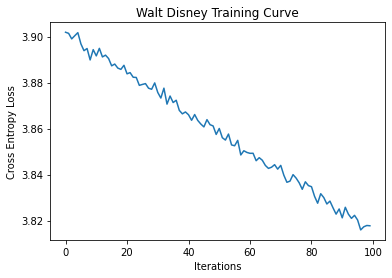

In [80]:
plt.plot(wd_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iterations')
plt.title('Walt Disney Training Curve')
plt.show()

In [82]:
wd_trainer.evaluate(seed_sequence="On a dark and mysterious", output_length=100)

'On a dark and mysteriousnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn'

#### Scrap Code

In [ ]:
class GRU(nn.Module):
    """
    Implement a Deep GRU that can take an arbitrary number of GRU cells.
    """
    def __init__(self, input_dim, hidden_dim, m_layers):
        super(GRU, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.m_layers = m_layers
        self.layers = [GRUcell(input_dim, hidden_dim)] + [GRUcell(hidden_dim, hidden_dim)]*(m_layers-1)
        
        
    def forward(self, X):
        outs = []
        # Initialize the hidden states as a list of tuples
        hiddens = [torch.zeros((X.shape[1], self.hidden_dim))]*self.m_layers 
        
        # Perform recurrent pass
        for i, x_t in enumerate(X):
            for j, layer in enumerate(self.layers):
                h_t = layer(x_t, hiddens[j])
                # Update the hidden states for that layer @this timestep
                hiddens[j] = h_t
                # Update the input to the next layer @this timestep
                x_t = h_t
            # At the end of layer append the hidden state (output)
            outs.append(h_t)
        return torch.stack(outs, dim=0), h_t

In [31]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, m_layers=1):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.m_layers = m_layers
        self.hidden_layers = [RNNcell(input_dim, hidden_dim)] + [RNNcell(hidden_dim, hidden_dim)]*(m_layers-1)
        
    def forward(self, X):
        outs = []
        # Initialize the hidden states as a list of zeroes, one for each layer
        hiddens = [torch.zeros((X.shape[1], self.hidden_dim))]*self.m_layers 
        
        # Perform recurrent pass over timesteps
        for i, x_t in enumerate(x):
            for j, layer in enumerate(self.hidden_layers):
                h_t = layer(x_t, hiddens[j])
                # Update the hidden states for that layer @this timestep
                hiddens[j] = h_t
                # Update the input to the next layer @this timestep
                x_t = h_t
            # At the end of layer append the hidden state (output)
            outs.append(h_t)
        return torch.stack(outs, dim=0), h_t
    